# Doom Playing Deep Q

## Game Setup

In [2]:
import tensorflow as tf      # Deep Learning library
import numpy as np           # Handle matrices
from vizdoom import *        # Doom Environment

import random                # Handling random number generation
import time                  # Handling time calculation
from skimage import transform# Help us to preprocess the frames

from collections import deque# Ordered collection with ends
import matplotlib.pyplot as plt # Display graphs

import warnings # This ignore all the warning messages that are normally printed during the training because of skiimage
warnings.filterwarnings('ignore')

In [3]:
def show_image(img):
    from matplotlib import pyplot as plt
    import cv2
    plt.imshow(img)
    plt.show()

In [22]:
def setupGame():
    game = DoomGame()
    game.load_config("basic.cfg")
    game.set_doom_scenario_path("basic.wad")
    game.set_window_visible(False)
    game.init()
  
    left  = [1, 0, 0]
    right = [0, 1, 0]
    fire  = [0, 0, 1]
    actions = [left, right, fire]
  
    return game, actions

## Test Doom on it's own

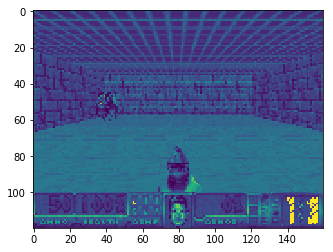

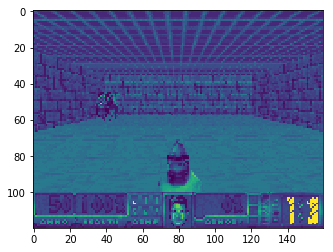

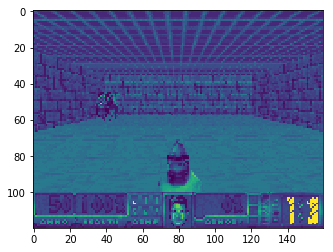

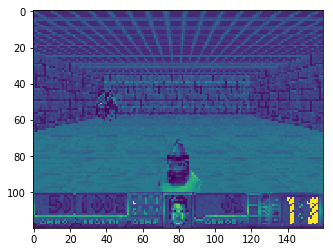

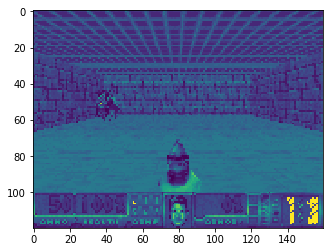

In [53]:
from IPython.display import display

game, actions = setupGame()
game.new_episode()
for i in range(5):
    state = game.get_state()
    img = state.screen_buffer
    show_image(img)
    if game.is_episode_finished():
        break;
    action = random.choice(actions)
    game.make_action(action)
    time.sleep(0.2)
game.close() 


## Image Processing

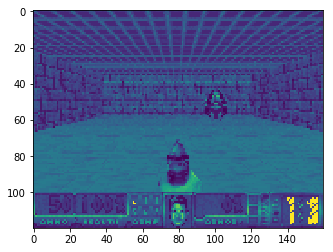

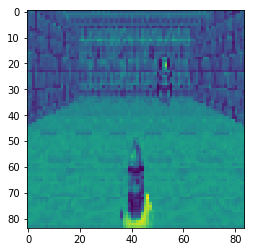

In [8]:
def preprocess_frame(frame, x, y):
    cropped = frame[30:-20,:]
    normalized = cropped / 255.0
    return transform.resize(normalized, [x, y])
show_image(img)
show_image(preprocess_frame(img, 84, 84))

In [97]:
class StackedFrames:
    def __init__(self, x, y, t):
        self.x = x
        self .y = y
        self.t = t
        self.deque = deque(maxlen=t)

    def add_initial_frame(self, frame):
        processed = preprocess_frame(frame, self.x, self.y)
        for i in range(self.t):
            self.deque.append(processed)

    def add_frame(self, frame):
        processed = preprocess_frame(frame, self.x, self.y)
        self.deque.append(processed)

    def state(self):
        return np.stack(self.deque, axis=2)

## Neuronal Network

In [54]:
def conv_with_norm_elu(inputs, filters, kernel_size, strides, name):
    conv = tf.layers.conv2d(inputs = inputs,
        filters = filters,
        kernel_size = kernel_size,
        strides = strides,
        padding = "VALID",
        name = name)
    batch = tf.layers.batch_normalization(inputs = conv,
        training = True,
        name = name + "_batch")
    out = tf.nn.elu(batch, name = name + "_activation")
    return conv, out
    

class DoomNN:
    def __init__(self, state_size, action_size, learning_rate):
        self.inputs = tf.placeholder(tf.float32, [None, *state_size], name = "inputs")
        self.actions = tf.placeholder(tf.float32, [None, action_size], name = "actions")
        self.target_Q = tf.placeholder(tf.float32, [None], name="targetQ")
        
        self.conv1, self.conv1_out = conv_with_norm_elu(self.inputs,
            filters = 32,
            kernel_size = 8,
            strides = 2,
            name = "conv1")
        self.conv2, self.conv2_out = conv_with_norm_elu(self.conv1_out,
            filters = 64,
            kernel_size = 4,
            strides = 2,
            name = "conv2")
        self.conv3, self.conv3_out = conv_with_norm_elu(self.conv2_out,
            filters = 128,
            kernel_size = 4,
            strides = 2,
            name = "conv3")
        self.flat = tf.contrib.layers.flatten(self.conv3_out)
        self.fc = tf.layers.dense(inputs = self.flat,
            units = 512,
            activation = tf.nn.elu,
            name = "fc")
        self.output = tf.layers.dense(inputs = self.fc,
            units = action_size,
            activation = None,
            name = "output")
        self.predicted_Q = tf.reduce_sum(tf.multiply(self.output, self.actions))
        
        self.loss = tf.reduce_mean(tf.square(self.predicted_Q - self.target_Q))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)
        

In [55]:
from collections import namedtuple
Experience = namedtuple("Experience", "state_before action state_after reward done")

class Memory:
    def __init__(self, size):
        self.deque = deque(maxlen=size)
    
    def remember(self, experience):
        self.deque.append(experience)
    
    def sample(self, n):
        indices = np.random.choice(len(self.deque), n, False)    
        return [self.deque[i] for i in indices]

In [123]:
class GameRepr:
    def __init__(self, x, y, t):
        self.game, self.actions = setupGame()
        self.frames = StackedFrames(x, y, t)
        self._new_episode()
        self.frame_shape = self.game.get_state().screen_buffer.shape
        
    
    def step(self, action):
        old_state = self.frames.state()
        reward, done = self._perform_action(action)
        new_state = self.frames.state()
        if done:
            self._new_episode() # restart
        return Experience(state_before = old_state,
            state_after = new_state,
            action = action,
            reward = reward,
            done = done)
    
    def reset(self):
        self._new_episode();
        return self.frames.state()

    def _new_episode(self):
        self.game.new_episode()
        frame = self.game.get_state().screen_buffer
        self.frames.add_initial_frame(frame)

    def _perform_action(self, action):
        reward = self.game.make_action(action)
        done = self.game.is_episode_finished()
        if done:
            frame = np.zeros(self.frame_shape)
            self.frames.add_frame(frame)
            return reward, True
        else:
            frame = self.game.get_state().screen_buffer
            self.frames.add_frame(frame)
            return reward, False

In [57]:
def pretrain(game, memory, n):
    game.reset()
    for i in range(n):
        action = np.random.choice(len(game.actions))
        exp = game.step(game.actions[action])
        memory.remember(exp)

In [217]:
def predict_action(s, game, dnn, state):
    qs = s.run(dnn.output, feed_dict = {
        dnn.inputs: state.reshape((1, *state.shape))
    })
    choice = np.argmax(qs)
    return game.actions[choice]

def chose_action(s, game, dnn, state, exploration_rate):
    if np.random.rand() < exploration_rate:
        choice = random.randint(1, len(game.actions))-1
        return game.actions[choice]
    return predict_action(s, game, dnn, state)

In [218]:
def learn_step(s, memory, dnn, batch_size, gamma, summary_op):
    batch = memory.sample(batch_size)
    b_states_before = np.array([e.state_before for e in batch], ndmin=3)
    b_states_after  = np.array([e.state_after  for e in batch], ndmin=3)
    b_actions = np.array([e.action for e in batch])
  
    b_Q_next = s.run(dnn.output, feed_dict = {
      dnn.inputs: b_states_after
    })
    
    b_target_Q = []
    for i, e in enumerate(batch):
        if e.done:
            b_target_Q.append(e.reward)
        else:
            q = e.reward + gamma*np.max(b_Q_next[i])
            b_target_Q.append(q)

    feed = {
        dnn.inputs: b_states_before,
        dnn.actions: b_actions,
        dnn.target_Q: b_target_Q}
    loss, _, summary = s.run([dnn.loss, dnn.optimizer, summary_op], feed_dict=feed)
    return loss, summary

In [215]:
def learn_episode(game, max_steps, chose, learn_step, report):
    state = game.reset()
    total_reward = 0
    step = 0
    last_loss = None
    while step < max_steps:
        action = chose(state)
        
        exp = game.step(action)
        total_reward += exp.reward
        if exp.done:
          # TODO process "learning?"
          break
    
        last_loss, summary = learn_step()
        report(summary, step)
    
        step += 1
    return step, total_reward, last_loss

In [230]:
def report_progress(writer, summary, episode):
    writer.add_summary(summary, episode)
    writer.flush()

def learn(s, game,  memory, nn, writer, episodes, max_steps, batch_size, gamma, min_exploration, exploration_decay):
    saver = tf.train.Saver(max_to_keep=10)
    exploration_rate = 1

    # Reporting
    tf.summary.scalar("Loss", nn.loss)
    report_op = tf.summary.merge_all()

    ls = lambda: learn_step(s, memory, nn, batch_size, gamma, report_op)
    ch = lambda state: chose_action(s, game, nn, state, exploration_rate)

    pretrain(game, memory, batch_size)
    for episode in range(episodes):
        r = lambda summary, step: report_progress(writer, summary, episode)
        steps, total_reward, last_loss = learn_episode(game, max_steps, ch, ls, r)
        print('Episode: {}'.format(episode),
              'Total reward: {}'.format(total_reward),
              'Training loss: {:.4f}'.format(last_loss),
              'Explore P: {:.4f}'.format(exploration_rate))
        if episode % 5 == 0:
            save_path = saver.save(s, "./models/doom-deepQ", global_step=episode)
            print(" saved model snapshot: ", save_path)
        exploration_rate = max(exploration_rate * (1-exploration_decay), min_exploration)

In [ ]:
def evaluate_episode(s, game, nn, max_steps):
    state = game.reset
    step = 0
    while step < max_steps:
        action = predict_action(s, game, nn, state)
        state = game.

In [245]:
tf.reset_default_graph()

x = 84
y = 84
t = 4

learning_rate = 0.00025
batch_size = 64
memory_size = 1000000
max_steps = 100
gamma = 0.9 # discounting rate
min_exploration = 0.1
exploration_decay = 0.05

game = GameRepr(x,y,t)
frames = StackedFrames(x, y, t)
memory = Memory(memory_size)
nn = DoomNN(state_size=[x,y,t], action_size=len(game.actions), learning_rate=learning_rate)

In [246]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Setup TensorBoard Writer
writer = tf.summary.FileWriter("/tmp/tensorboard/dqn/1")

In [247]:
#learn(game, memory, nn, writer, episodes, max_steps, batch_size, gamma)
learn(sess, game, memory, nn, writer, 100, max_steps, 64, gamma, min_exploration, exploration_decay)

Episode: 0 Total reward: -125.0 Training loss: 3.2583 Explore P: 1.0000
 saved model snapshot:  ./models/doom-deepQ-0
Episode: 1 Total reward: 94.0 Training loss: 3.0267 Explore P: 0.9500
Episode: 2 Total reward: -125.0 Training loss: 2.1098 Explore P: 0.9025
Episode: 3 Total reward: -120.0 Training loss: 2.1098 Explore P: 0.8574
Episode: 4 Total reward: 73.0 Training loss: 2.1098 Explore P: 0.8145
Episode: 5 Total reward: 94.0 Training loss: 2.1098 Explore P: 0.7738
 saved model snapshot:  ./models/doom-deepQ-5
Episode: 6 Total reward: 54.0 Training loss: 2.1098 Explore P: 0.7351
Episode: 7 Total reward: -130.0 Training loss: 2.1098 Explore P: 0.6983
Episode: 8 Total reward: -125.0 Training loss: 2.1098 Explore P: 0.6634
Episode: 9 Total reward: 88.0 Training loss: 2.1098 Explore P: 0.6302
Episode: 10 Total reward: 93.0 Training loss: 2.1098 Explore P: 0.5987
 saved model snapshot:  ./models/doom-deepQ-10
Episode: 11 Total reward: 93.0 Training loss: 2.1098 Explore P: 0.5688
Episode: 